# Import dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Filter sequences 

In [2]:
def read_fasta(filepath):
    sequences = []
    with open(filepath, 'r') as file:
        seq = ''
        for idx, line in enumerate(file):
            line = line.strip()
            if line.startswith('>'):
                if idx == 0:
                    continue
                sequences.append(seq)
                seq = ''
            else:
                seq += line
        if len(seq) > 0:
            sequences.append(seq)
    return sequences


fasta_file = "/home/thanhtvt1/workspace/Directed_Evolution/data/uniprot_sprot.fasta"
sequences = read_fasta(fasta_file)
print("Total no. sequences =", len(sequences))

Total no. sequences = 569793


In [3]:
def filter_seqs(sequences, excluded_residues, max_length: int = 1024):
    new_seqs = []
    for seq in sequences:
        if len(seq) > max_length:
            continue
        if any(residue in seq for residue in excluded_residues):
            continue
        new_seqs.append(seq)
    return new_seqs

# Filter by length
max_seq_lens = 1024
excluded_residues = ['X', 'Z', 'B', 'U', 'O']
seqs = filter_seqs(sequences, excluded_residues, max_seq_lens)

# Filter by 
seq_lens = [len(seq) for seq in seqs]
print("Total no. sequences =", len(seqs))
tmp_df = pd.DataFrame(seq_lens, columns=["sequence length"])
tmp_df.describe()

Total no. sequences = 549431


,sequence length
count,549431.00000
mean,321.81281
std,201.07396
min,2.00000
25%,165.00000
50%,286.00000
75%,431.00000
max,1024.00000


<Axes: ylabel='Count'>

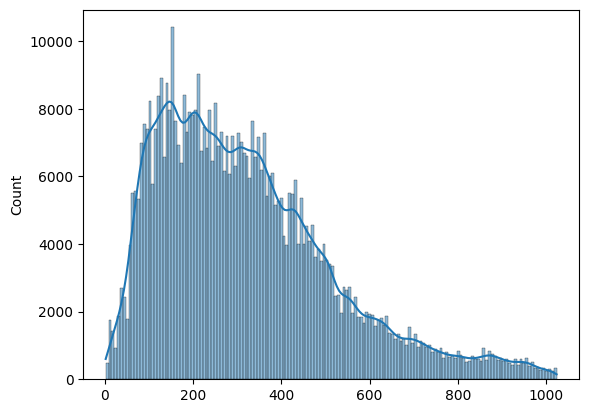

In [4]:
sns.histplot(seq_lens, kde=True)

# Get k-mers

In [5]:
from collections import defaultdict


def extract_kmers_from_sequence(sequence, k, kmers2int):
    for i in range(len(sequence) - k + 1):
        kmer = sequence[i:i + k]
        kmers2int[kmer] += 1
    return kmers2int


def extract_non_overlap_kmers_from_sequence(sequence, k, kmers2int):
    for i in range(0, len(sequence), k):
        if i > len(sequence) - k:
            # kmer = sequence[i:] + 'O' * (len(sequence) - i - 1)
            # kmers2int[kmer] += 1
            break
        kmer = sequence[i:i + k]
        kmers2int[kmer] += 1
    return kmers2int


def extract_kmers(sequences, k: int = 3):
    kmers_counter = defaultdict(lambda: 0, {})
    for seq in sequences:
        kmers_counter = extract_non_overlap_kmers_from_sequence(seq, k, kmers_counter)
    return dict(kmers_counter)

In [6]:
kmers_counter = extract_kmers(seqs, k=3)

In [7]:
print(len(list(kmers_counter.keys())))

8000


In [8]:
kmer, counter = list(kmers_counter.keys()), list(kmers_counter.values())
data = {"k-mer": kmer, "count": counter}
kmer_df = pd.DataFrame.from_dict(data)
kmer_df

,k-mer,count
0,MAF,6123
1,SAE,17137
2,DVL,25066
3,KEY,8311
4,DRR,8915
...,...,...
7995,YWH,741
7996,WRH,988
7997,YWW,527
7998,WWC,130


In [9]:
kmer_df.describe()

,count
count,8000.000000
mean,7344.225250
std,6589.987434
min,115.000000
25%,2520.750000
50%,5395.500000
75%,10086.250000
max,71108.000000


# Split sequences

In [10]:
def split_seqs2kmers(seqs, k, split_when_return=False):
    new_seqs = []
    for seq in seqs:
        splitted_seq = '<s>'
        for i in range(0, len(seq), k):
            # if i > len(seq) - k:
            #     kmer = sequence[i:] + 'O' * (len(sequence) - i - 1)
            #     kmers2int[kmer] += 1
            #     break
            splitted_seq = splitted_seq + ' ' + seq[i:i + k]

        splitted_seq = splitted_seq + ' ' + '</s>'
        if split_when_return:
            new_seqs.append(splitted_seq.strip().split(" "))
        else:    
            new_seqs.append(splitted_seq.strip())
    return new_seqs

In [11]:
splitted_seqs = split_seqs2kmers(seqs, k=3, split_when_return=True)
splitted_seqs[0]

['<s>',
 'MAF',
 'SAE',
 'DVL',
 'KEY',
 'DRR',
 'RRM',
 'EAL',
 'LLS',
 'LYY',
 'PND',
 'RKL',
 'LDY',
 'KEW',
 'SPP',
 'RVQ',
 'VEC',
 'PKA',
 'PVE',
 'WNN',
 'PPS',
 'EKG',
 'LIV',
 'GHF',
 'SGI',
 'KYK',
 'GEK',
 'AQA',
 'SEV',
 'DVN',
 'KMC',
 'CWV',
 'SKF',
 'KDA',
 'MRR',
 'YQG',
 'IQT',
 'CKI',
 'PGK',
 'VLS',
 'DLD',
 'AKI',
 'KAY',
 'NLT',
 'VEG',
 'VEG',
 'FVR',
 'YSR',
 'VTK',
 'QHV',
 'AAF',
 'LKE',
 'LRH',
 'SKQ',
 'YEN',
 'VNL',
 'IHY',
 'ILT',
 'DKR',
 'VDI',
 'QHL',
 'EKD',
 'LVK',
 'DFK',
 'ALV',
 'ESA',
 'HRM',
 'RQG',
 'HMI',
 'NVK',
 'YIL',
 'YQL',
 'LKK',
 'HGH',
 'GPD',
 'GPD',
 'ILT',
 'VKT',
 'GSK',
 'GVL',
 'YDD',
 'SFR',
 'KIY',
 'TDL',
 'GWK',
 'FTP',
 'L',
 '</s>']

In [83]:
import itertools

a = list(itertools.chain.from_iterable(splitted_seqs))
len(a)

60220412

In [45]:
import itertools


def freq_of_unique_tokens(seqs):
    bag_of_toks = list(itertools.chain.from_iterable(seqs))
    corpus_count = 0
    count = {}
    for tok in bag_of_toks:
        if tok in count:
            count[tok] += 1
        else:
            count[tok] = 1
        if tok != '<s>' and tok != '</s>':
            corpus_count += 1

    unique_word_count = len(count) - 2
    print("No of unique words in corpus : "+ str(unique_word_count))
    print("No of words in corpus: "+ str(corpus_count))
    
    return count


def compute_bigram_frequencies(seqs):
    bigram_frequencies = dict()
    given_toks, toks = [], []
    for seq in seqs:
        given_token = None
        for tok in seq:
            if given_token is not None:
                bigram_frequencies[(given_token, tok)] = bigram_frequencies.get((given_token, tok), 0) + 1
            given_token = tok
    return bigram_frequencies, given_toks, toks


def compute_bigram_probs(bigram_freqs, count):
    """P(aa_{t}|aa_{t-1}) = P(aa_{t}, aa_{t-1}) / P(aa_{t-1})"""
    bigram_probs = dict()
    for key in bigram_freqs:
        numerator = bigram_freqs.get(key)
        denominator = count.get(key[0])
        if numerator == 0 or denominator == 0:
            bigram_probs[key] = 0
        else:
            bigram_probs[key] = numerator / denominator
    return bigram_probs

In [46]:
unique_word_frequency = freq_of_unique_tokens(splitted_seqs)
unique_word_frequency

No of unique words in corpus : 8420
No of words in corpus: 59121550


{'<s>': 549431,
 'MAF': 6123,
 'SAE': 17137,
 'DVL': 25066,
 'KEY': 8311,
 'DRR': 8915,
 'RRM': 5361,
 'EAL': 43292,
 'LLS': 39580,
 'LYY': 5238,
 'PND': 4909,
 'RKL': 19518,
 'LDY': 10539,
 'KEW': 2566,
 'SPP': 9609,
 'RVQ': 7385,
 'VEC': 2583,
 'PKA': 9099,
 'PVE': 12821,
 'WNN': 1378,
 'PPS': 11882,
 'EKG': 16170,
 'LIV': 18201,
 'GHF': 4104,
 'SGI': 17221,
 'KYK': 5791,
 'GEK': 17629,
 'AQA': 22068,
 'SEV': 14855,
 'DVN': 7930,
 'KMC': 597,
 'CWV': 637,
 'SKF': 6601,
 'KDA': 14846,
 'MRR': 6444,
 'YQG': 5137,
 'IQT': 6282,
 'CKI': 2208,
 'PGK': 10780,
 'VLS': 26965,
 'DLD': 18220,
 'AKI': 15473,
 'KAY': 8112,
 'NLT': 12572,
 'VEG': 19592,
 'FVR': 8486,
 'YSR': 6508,
 'VTK': 11606,
 'QHV': 3636,
 'AAF': 16148,
 'LKE': 31520,
 'LRH': 8752,
 'SKQ': 8099,
 'YEN': 4890,
 'VNL': 13959,
 'IHY': 2353,
 'ILT': 17906,
 'DKR': 7133,
 'VDI': 14160,
 'QHL': 6211,
 'EKD': 12666,
 'LVK': 21437,
 'DFK': 7376,
 'ALV': 33935,
 'ESA': 14418,
 'HRM': 1872,
 'RQG': 9022,
 'HMI': 1219,
 'NVK': 9061,
 'Y

In [48]:
bigram_freqs, given_tokens, tokens = compute_bigram_frequencies(splitted_seqs)
bigram_freqs

{('<s>', 'MAF'): 1932,
 ('MAF', 'SAE'): 1,
 ('SAE', 'DVL'): 19,
 ('DVL', 'KEY'): 6,
 ('KEY', 'DRR'): 2,
 ('DRR', 'RRM'): 1,
 ('RRM', 'EAL'): 3,
 ('EAL', 'LLS'): 21,
 ('LLS', 'LYY'): 1,
 ('LYY', 'PND'): 1,
 ('PND', 'RKL'): 1,
 ('RKL', 'LDY'): 199,
 ('LDY', 'KEW'): 1,
 ('KEW', 'SPP'): 2,
 ('SPP', 'RVQ'): 1,
 ('RVQ', 'VEC'): 2,
 ('VEC', 'PKA'): 1,
 ('PKA', 'PVE'): 1,
 ('PVE', 'WNN'): 1,
 ('WNN', 'PPS'): 1,
 ('PPS', 'EKG'): 2,
 ('EKG', 'LIV'): 10,
 ('LIV', 'GHF'): 1,
 ('GHF', 'SGI'): 1,
 ('SGI', 'KYK'): 1,
 ('KYK', 'GEK'): 7,
 ('GEK', 'AQA'): 3,
 ('AQA', 'SEV'): 5,
 ('SEV', 'DVN'): 9,
 ('DVN', 'KMC'): 1,
 ('KMC', 'CWV'): 1,
 ('CWV', 'SKF'): 1,
 ('SKF', 'KDA'): 1,
 ('KDA', 'MRR'): 1,
 ('MRR', 'YQG'): 1,
 ('YQG', 'IQT'): 1,
 ('IQT', 'CKI'): 1,
 ('CKI', 'PGK'): 1,
 ('PGK', 'VLS'): 6,
 ('VLS', 'DLD'): 8,
 ('DLD', 'AKI'): 3,
 ('AKI', 'KAY'): 1,
 ('KAY', 'NLT'): 25,
 ('NLT', 'VEG'): 7,
 ('VEG', 'VEG'): 11,
 ('VEG', 'FVR'): 3,
 ('FVR', 'YSR'): 1,
 ('YSR', 'VTK'): 1,
 ('VTK', 'QHV'): 2,
 ('QHV', '

In [49]:
bigram_probs = compute_bigram_probs(bigram_freqs, unique_word_frequency)

In [50]:
bigram_probs

{('<s>', 'MAF'): 0.0035163651122706945,
 ('MAF', 'SAE'): 0.00016331863465621427,
 ('SAE', 'DVL'): 0.0011087121433156328,
 ('DVL', 'KEY'): 0.00023936806829968882,
 ('KEY', 'DRR'): 0.0002406449284081338,
 ('DRR', 'RRM'): 0.00011217049915872125,
 ('RRM', 'EAL'): 0.0005595970900951316,
 ('EAL', 'LLS'): 0.0004850780744710339,
 ('LLS', 'LYY'): 2.5265285497726124e-05,
 ('LYY', 'PND'): 0.00019091256204658267,
 ('PND', 'RKL'): 0.00020370747606437156,
 ('RKL', 'LDY'): 0.010195716774259657,
 ('LDY', 'KEW'): 9.48856627763545e-05,
 ('KEW', 'SPP'): 0.000779423226812159,
 ('SPP', 'RVQ'): 0.00010406910188365075,
 ('RVQ', 'VEC'): 0.00027081922816519973,
 ('VEC', 'PKA'): 0.00038714672861014324,
 ('PKA', 'PVE'): 0.00010990218705352236,
 ('PVE', 'WNN'): 7.799703611262772e-05,
 ('WNN', 'PPS'): 0.000725689404934688,
 ('PPS', 'EKG'): 0.000168321831341525,
 ('EKG', 'LIV'): 0.0006184291898577613,
 ('LIV', 'GHF'): 5.494203615185979e-05,
 ('GHF', 'SGI'): 0.00024366471734892786,
 ('SGI', 'KYK'): 5.806863712908658

In [57]:
# bigram_data = {"bigram": bigram_probs.keys(), "probs": bigram_probs.values(), "count": bigram_freqs.values()}
bigram_data = {"given_tokens": [tok[0] for tok in bigram_probs.keys()],
               "tokens": [tok[1] for tok in bigram_probs.keys()],
               "bigram": bigram_probs.keys(),
               "probs": bigram_probs.values(),
               "count": bigram_freqs.values()}
bigram_df = pd.DataFrame.from_dict(bigram_data)
bigram_df

,given_tokens,tokens,bigram,probs,count
0,<s>,MAF,"(<s>, MAF)",0.003516,1932
1,MAF,SAE,"(MAF, SAE)",0.000163,1
2,SAE,DVL,"(SAE, DVL)",0.001109,19
3,DVL,KEY,"(DVL, KEY)",0.000239,6
4,KEY,DRR,"(KEY, DRR)",0.000241,2
...,...,...,...,...,...
18146031,LKC,SNH,"(LKC, SNH)",0.000318,1
18146032,LKC,LTL,"(LKC, LTL)",0.000318,1
18146033,LTL,MLR,"(LTL, MLR)",0.000035,1
18146034,LVF,ENS,"(LVF, ENS)",0.000077,1


In [58]:
bigram_df.describe(percentiles=[0.25, 0.5, 0.75, 0.95])

,probs,count
count,1.814604e+07,1.814604e+07
mean,4.640683e-04,3.288376e+00
std,4.988634e-03,1.655838e+01
min,1.820065e-06,1.000000e+00
25%,1.158614e-04,1.000000e+00
50%,2.148228e-04,2.000000e+00
75%,4.273870e-04,3.000000e+00
95%,1.340632e-03,1.000000e+01
max,1.000000e+00,2.144700e+04


# Processing bigram df

In [59]:
# Filter bigram with count < 10
high_bigram_df = bigram_df[bigram_df["count"] >= 10]
high_bigram_df

,given_tokens,tokens,bigram,probs,count
0,<s>,MAF,"(<s>, MAF)",0.003516,1932
2,SAE,DVL,"(SAE, DVL)",0.001109,19
7,EAL,LLS,"(EAL, LLS)",0.000485,21
11,RKL,LDY,"(RKL, LDY)",0.010196,199
21,EKG,LIV,"(EKG, LIV)",0.000618,10
...,...,...,...,...,...
18141910,GMA,EIL,"(GMA, EIL)",0.001710,15
18141984,RQQ,PLP,"(RQQ, PLP)",0.001954,14
18141985,VSP,IVM,"(VSP, IVM)",0.001220,15
18141986,LCG,MSI,"(LCG, MSI)",0.002067,14


In [71]:
# Filter bigram with last token is length < 3
high_k_only_bigram_df = high_bigram_df[high_bigram_df["tokens"].str.len() >= 3]
high_k_only_bigram_df = high_k_only_bigram_df[high_k_only_bigram_df["given_tokens"].str.len() >= 3]
high_k_only_bigram_df

,given_tokens,tokens,bigram,probs,count
0,<s>,MAF,"(<s>, MAF)",0.003516,1932
2,SAE,DVL,"(SAE, DVL)",0.001109,19
7,EAL,LLS,"(EAL, LLS)",0.000485,21
11,RKL,LDY,"(RKL, LDY)",0.010196,199
21,EKG,LIV,"(EKG, LIV)",0.000618,10
...,...,...,...,...,...
18141909,FWA,GIS,"(FWA, GIS)",0.007306,16
18141910,GMA,EIL,"(GMA, EIL)",0.001710,15
18141984,RQQ,PLP,"(RQQ, PLP)",0.001954,14
18141985,VSP,IVM,"(VSP, IVM)",0.001220,15


In [76]:
# Filter <s> and </s> token
high_k_only_bigram_df = high_k_only_bigram_df[high_k_only_bigram_df["given_tokens"] != "<s>"]
high_k_only_bigram_df = high_k_only_bigram_df[high_k_only_bigram_df["tokens"] != "</s>"]
high_k_only_bigram_df

,given_tokens,tokens,bigram,probs,count
2,SAE,DVL,"(SAE, DVL)",0.001109,19
7,EAL,LLS,"(EAL, LLS)",0.000485,21
11,RKL,LDY,"(RKL, LDY)",0.010196,199
21,EKG,LIV,"(EKG, LIV)",0.000618,10
42,KAY,NLT,"(KAY, NLT)",0.003082,25
...,...,...,...,...,...
18141909,FWA,GIS,"(FWA, GIS)",0.007306,16
18141910,GMA,EIL,"(GMA, EIL)",0.001710,15
18141984,RQQ,PLP,"(RQQ, PLP)",0.001954,14
18141985,VSP,IVM,"(VSP, IVM)",0.001220,15


In [80]:
high_k_only_bigram_df.describe(percentiles=[0.25, 0.5, 0.75, 0.95])

,probs,count,log_prob
count,983253.000000,983253.000000,983253.000000
mean,0.002346,21.149155,-6.598183
std,0.004933,24.193058,0.906278
min,0.000141,10.000000,-8.869370
25%,0.000713,11.000000,-7.246044
50%,0.001185,15.000000,-6.737797
75%,0.002266,22.000000,-6.089649
95%,0.007485,54.000000,-4.894914
max,0.673822,5484.000000,-0.394789


In [79]:
high_k_only_bigram_df["log_prob"] = np.log(high_k_only_bigram_df["probs"])
high_k_only_bigram_df

,given_tokens,tokens,bigram,probs,count,log_prob
2,SAE,DVL,"(SAE, DVL)",0.001109,19,-6.804556
7,EAL,LLS,"(EAL, LLS)",0.000485,21,-7.631201
11,RKL,LDY,"(RKL, LDY)",0.010196,199,-4.585788
21,EKG,LIV,"(EKG, LIV)",0.000618,10,-7.388328
42,KAY,NLT,"(KAY, NLT)",0.003082,25,-5.782224
...,...,...,...,...,...,...
18141909,FWA,GIS,"(FWA, GIS)",0.007306,16,-4.919068
18141910,GMA,EIL,"(GMA, EIL)",0.001710,15,-6.371498
18141984,RQQ,PLP,"(RQQ, PLP)",0.001954,14,-6.237627
18141985,VSP,IVM,"(VSP, IVM)",0.001220,15,-6.708735


<Axes: xlabel='bigram', ylabel='log_prob'>

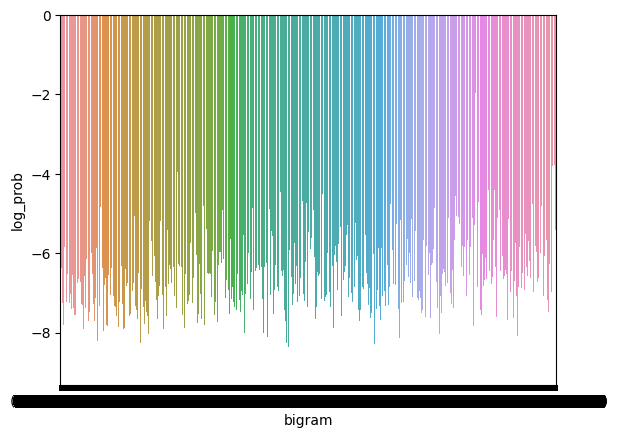

In [81]:
sns.barplot(data=high_k_only_bigram_df, x="bigram", y="log_prob")